In [1]:
 # Having to use Python 2 for astrometry.net compatibility so...
from __future__ import division, print_function, unicode_literals
# Importing all other required libraries.
import os
import ccdproc
import glob
import subprocess
import itertools
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import utils as wcsutils
from astropy.table import Table
from astropy.stats import sigma_clip
from astroquery.simbad import Simbad
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc, rcParams

In [2]:
%matplotlib inline

In [3]:
rc('text', usetex=True)
rcParams.update({'font.size': 14})

## Directory & file names

In [4]:
# Creating a dictionary of data paths.
paths = {'calib':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/calib/RASA', \
         'config':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/configs', \
         'red':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/reduced/RASA', \
         'temp':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/temp', \
         'raw':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/raw'}

bias_file = '20151008_MasterBias_0sec_-20C_sca(50x0s).fts'
dark_file = '20151008_MasterDark_300sec_-20C_sca(50x300s).fts'
unbiased_dark_file = ''
flat_file = '20151005_MasterFlat1_avgof15x1s_-20C.fts'


In [5]:
# Creating a dictionary of data paths.
paths2 = {'calib':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/calib/Canon', \
         'config':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/configs', \
         'red':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/reduced/Canon', \
         'temp':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/PSF/RASA/RASA-mono/temp', \
         'raw':'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23'}

bias_file2 = 'master_bias.fits'
dark_file2 = 'master_dark.fits'
unbiased_dark_file2 = 'master_unbiased_dark.fits'
flat_file2 = 'master_flat.fits'

## Basic reduction

### Assemble calibration files

In [6]:
master_bias = ccdproc.CCDData.read(os.path.join(paths['calib'], bias_file), unit='adu')
master_dark = ccdproc.CCDData.read(os.path.join(paths['calib'], dark_file), unit='adu')
if unbiased_dark_file:
    master_unbiased_dark = ccdproc.CCDData.read(os.path.join(paths['calib'], unbiased_dark_file), unit='adu')
else:
    master_unbiased_dark = ccdproc.subtract_bias(master_dark, master_bias)
master_flat = ccdproc.CCDData.read(os.path.join(paths['calib'], flat_file), unit='adu')    

In [7]:
master_bias2 = ccdproc.CCDData.read(os.path.join(paths2['calib'], bias_file2))
master_dark2 = ccdproc.CCDData.read(os.path.join(paths2['calib'], dark_file2))
if unbiased_dark_file2:
    master_unbiased_dark2 = ccdproc.CCDData.read(os.path.join(paths2['calib'], unbiased_dark_file2))
else:
    master_unbiased_dark2 = ccdproc.subtract_bias(master_dark, master_bias)
master_flat2 = ccdproc.CCDData.read(os.path.join(paths2['calib'], flat_file2))  

### Get lists of raw files

In [8]:
centred = glob.glob(os.path.join(paths['raw'], 'VegaCentered*V*.fit'))
offcentre = glob.glob(os.path.join(paths['raw'], 'VegaOffCenter*V*.fit'))

In [9]:
target = 'Fomalhaut'
fomalhaut = [name for name in glob.glob(os.path.join(paths2['raw'], '*_light.fits')) if fits.getval(name, 'TARGET') == 'Fomalhaut']
fomalhaut.sort()
fomalhautA = list(itertools.chain([fomalhaut[-1],], fomalhaut[0:10]))
fomalhautB = fomalhaut[11:-2]
fomalhautB

[u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_21_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_22_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_23_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_24_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_25_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_26_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_27_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_28_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_29_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_30_light.fits',
 u'/mnt/data/ajh/Documents/LSB/HuntsmanEye/data/raw/2014-09-23/83F011167_31_light.fits']

### Trim overscan region

In [10]:
os.chdir(paths2['temp'])

for raw in itertools.chain(fomalhautA, fomalhautB):
    on = ofn = os.path.basename(raw)
    image = ccdproc.CCDData.read(raw, unit='adu')
    image = ccdproc.trim_image(image[30:,:])
    ccdproc.CCDData.write(image, on, format='fits', clobber=True)
    print(on)

A floating-point value was expected. [astropy.wcs.wcs]
A floating-point value was expected.


83F011167_9_light.fits
83F011167_10_light.fits
83F011167_11_light.fits
83F011167_12_light.fits
83F011167_13_light.fits
83F011167_14_light.fits
83F011167_15_light.fits
83F011167_16_light.fits
83F011167_17_light.fits
83F011167_18_light.fits
83F011167_19_light.fits
83F011167_21_light.fits
83F011167_22_light.fits
83F011167_23_light.fits
83F011167_24_light.fits
83F011167_25_light.fits
83F011167_26_light.fits
83F011167_27_light.fits
83F011167_28_light.fits
83F011167_29_light.fits
83F011167_30_light.fits
83F011167_31_light.fits


### Use raw files & flat field to create weight & flag maps for each file

In [11]:
os.chdir(paths['temp'])

for raw in itertools.chain(centred, offcentre):
    cn = os.path.join(paths['config'], 'Vega.ww')
    wns = os.path.join(paths['calib'], flat_file) + ',' + raw
    own = os.path.basename(raw).replace('.fit', '.bdfw.weight.fits')
    ofn = os.path.basename(raw).replace('.fit', '.bdfw.flag.fits')
    command = "ww -c {} -WEIGHT_NAMES {} -OUTWEIGHT_NAME {} -OUTFLAG_NAME {}".format(cn, wns, own, ofn)
    subprocess.call(command, shell=True)
    print(own)
    
for raw in itertools.chain(fomalhautA, fomalhautB):
    cn = os.path.join(paths2['config'], 'Fomalhaut.ww')
    wns = os.path.join(paths2['calib'], flat_file2) + ',' + os.path.basename(raw)
    own = os.path.basename(raw).replace('.fits', '.bdfw.weight.fits')
    ofn = os.path.basename(raw).replace('.fits', '.bdfw.flag.fits')
    command = "ww -c {} -WEIGHT_NAMES {} -OUTWEIGHT_NAME {} -OUTFLAG_NAME {}".format(cn, wns, own, ofn)
    subprocess.call(command, shell=True)
    print(own)

VegaCentered-002V250s.bdfw.weight.fits
VegaCentered-003V100s.bdfw.weight.fits
VegaCentered-002V0p3.bdfw.weight.fits
VegaCentered-003V250s.bdfw.weight.fits
VegaCentered-003V0p1s.bdfw.weight.fits
VegaCentered-003V40s.bdfw.weight.fits
VegaCentered-003V16s.bdfw.weight.fits
VegaCentered-003V0p3.bdfw.weight.fits
VegaCentered-003V6p3.bdfw.weight.fits
VegaCentered-003V2p5.bdfw.weight.fits
VegaCentered-002V1p0s.bdfw.weight.fits
VegaCentered-003V1p0s.bdfw.weight.fits
VegaCentered-002V16s.bdfw.weight.fits
VegaCentered-002V6p3.bdfw.weight.fits
VegaCentered-002V2p5.bdfw.weight.fits
VegaCentered-002V100s.bdfw.weight.fits
VegaCentered-002V40s.bdfw.weight.fits
VegaCentered-002V0p1s.bdfw.weight.fits
VegaOffCenter-001V2p5.bdfw.weight.fits
VegaOffCenter-001V0p3.bdfw.weight.fits
VegaOffCenter-001V6p3.bdfw.weight.fits
VegaOffCenter-001V1p0s.bdfw.weight.fits
VegaOffCenter-001V100s.bdfw.weight.fits
VegaOffCenter-001V16s.bdfw.weight.fits
VegaOffCenter-001V40s.bdfw.weight.fits
VegaOffCenter-001V250s.bdfw.weigh

### Do bias & dark subtraction and flat fielding on the raw images.

In [12]:
os.chdir(paths['temp'])

for raw in itertools.chain(centred, offcentre):
    image = ccdproc.CCDData.read(raw, unit='adu')
    image = ccdproc.subtract_bias(image, master_bias)
    image = ccdproc.subtract_dark(image, master_unbiased_dark, scale=True, \
                                  data_exposure = image.header['EXPTIME'] * u.second, dark_exposure=300 * u.second)
    image = ccdproc.flat_correct(image, master_flat)
    on = os.path.basename(raw).replace('.fit', '.bdf.fits')
    print(on)
    ccdproc.CCDData.write(image, on, format='fits', clobber=True)
    
for raw in itertools.chain(fomalhautA, fomalhautB):
    image = ccdproc.CCDData.read(os.path.basename(raw))
    image = ccdproc.subtract_bias(image, master_bias2)
    image = ccdproc.subtract_dark(image, master_unbiased_dark2, scale=True, \
                                  data_exposure = image.header['EXPTIME'] * u.second, dark_exposure=300 * u.second)
    image = ccdproc.flat_correct(image, master_flat2)
    on = os.path.basename(raw).replace('.fits', '.bdf.fits')
    print(on)
    ccdproc.CCDData.write(image, on, format='fits', clobber=True)

VegaCentered-002V250s.bdf.fits
VegaCentered-003V100s.bdf.fits
VegaCentered-002V0p3.bdf.fits
VegaCentered-003V250s.bdf.fits
VegaCentered-003V0p1s.bdf.fits
VegaCentered-003V40s.bdf.fits
VegaCentered-003V16s.bdf.fits
VegaCentered-003V0p3.bdf.fits
VegaCentered-003V6p3.bdf.fits
VegaCentered-003V2p5.bdf.fits
VegaCentered-002V1p0s.bdf.fits
VegaCentered-003V1p0s.bdf.fits
VegaCentered-002V16s.bdf.fits
VegaCentered-002V6p3.bdf.fits
VegaCentered-002V2p5.bdf.fits
VegaCentered-002V100s.bdf.fits
VegaCentered-002V40s.bdf.fits
VegaCentered-002V0p1s.bdf.fits
VegaOffCenter-001V2p5.bdf.fits
VegaOffCenter-001V0p3.bdf.fits
VegaOffCenter-001V6p3.bdf.fits
VegaOffCenter-001V1p0s.bdf.fits
VegaOffCenter-001V100s.bdf.fits
VegaOffCenter-001V16s.bdf.fits
VegaOffCenter-001V40s.bdf.fits
VegaOffCenter-001V250s.bdf.fits
VegaOffCenter-001V0p1s.bdf.fits
83F011167_9_light.bdf.fits
83F011167_10_light.bdf.fits
83F011167_11_light.bdf.fits
83F011167_12_light.bdf.fits
83F011167_13_light.bdf.fits
83F011167_14_light.bdf.fits
83

### Use solve-field to get basic astrometric calibration

In [13]:
os.chdir(paths['temp'])

for raw in itertools.chain(centred, offcentre):
    orig = os.path.basename(raw).replace('.fit', '.bdf.fits')
    out = orig.replace('.bdf.fits', '.bdfw.fits')
    command = 'solve-field --no-plots --ra 279.3 --dec 38.8 --radius 5.0 --new-fits {} {}'.format(out, orig)
    subprocess.call(command, shell=True)
    print(out)
    
for raw in itertools.chain(fomalhautA, fomalhautB):
    orig = os.path.basename(raw).replace('.fits', '.bdf.fits')
    out = orig.replace('.bdf.fits', '.bdfw.fits')
    command = 'solve-field --no-plots --ra 344.4 --dec -29.6 --radius 2.0 --new-fits {} {}'.format(out, orig)
    subprocess.call(command, shell=True)
    print(out)

VegaCentered-002V250s.bdfw.fits
VegaCentered-003V100s.bdfw.fits
VegaCentered-002V0p3.bdfw.fits
VegaCentered-003V250s.bdfw.fits
VegaCentered-003V0p1s.bdfw.fits
VegaCentered-003V40s.bdfw.fits
VegaCentered-003V16s.bdfw.fits
VegaCentered-003V0p3.bdfw.fits
VegaCentered-003V6p3.bdfw.fits
VegaCentered-003V2p5.bdfw.fits
VegaCentered-002V1p0s.bdfw.fits
VegaCentered-003V1p0s.bdfw.fits
VegaCentered-002V16s.bdfw.fits
VegaCentered-002V6p3.bdfw.fits
VegaCentered-002V2p5.bdfw.fits
VegaCentered-002V100s.bdfw.fits
VegaCentered-002V40s.bdfw.fits
VegaCentered-002V0p1s.bdfw.fits
VegaOffCenter-001V2p5.bdfw.fits
VegaOffCenter-001V0p3.bdfw.fits
VegaOffCenter-001V6p3.bdfw.fits
VegaOffCenter-001V1p0s.bdfw.fits
VegaOffCenter-001V100s.bdfw.fits
VegaOffCenter-001V16s.bdfw.fits
VegaOffCenter-001V40s.bdfw.fits
VegaOffCenter-001V250s.bdfw.fits
VegaOffCenter-001V0p1s.bdfw.fits
83F011167_9_light.bdfw.fits
83F011167_10_light.bdfw.fits
83F011167_11_light.bdfw.fits
83F011167_12_light.bdfw.fits
83F011167_13_light.bdfw.fit

### Run SExtractor to prepare catalogues suitable for SCAMP

In [14]:
os.chdir(paths['temp'])

for raw in itertools.chain(centred, offcentre):
    cn = os.path.join(paths['config'], 'Vega.sex')
    pn = os.path.join(paths['config'], 'Vega.param')
    inn = os.path.basename(raw).replace('.fit', '.bdfw.fits')
    wn = inn.replace('.fits', '.weight.fits')
    fn = inn.replace('.fits', '.flag.fits')
    catn = inn.replace('.fits', '.cat')
    command = 'sex -c {} -CATALOG_NAME {} -PARAMETERS_NAME {} -WEIGHT_IMAGE {} -FLAG_IMAGE {} {}'.format(cn, catn, pn, wn, fn, inn)
    subprocess.call(command, shell=True)
    print(catn)
    
for raw in itertools.chain(fomalhautA, fomalhautB):
    cn = os.path.join(paths2['config'], 'Vega.sex')
    pn = os.path.join(paths2['config'], 'Vega.param')
    inn = os.path.basename(raw).replace('.fits', '.bdfw.fits')
    wn = inn.replace('.fits', '.weight.fits')
    fn = inn.replace('.fits', '.flag.fits')
    catn = inn.replace('.fits', '.cat')
    command = 'sex -c {} -CATALOG_NAME {} -PARAMETERS_NAME {} -WEIGHT_IMAGE {} -FLAG_IMAGE {} {}'.format(cn, catn, pn, wn, fn, inn)
    subprocess.call(command, shell=True)
    print(catn)

VegaCentered-002V250s.bdfw.cat
VegaCentered-003V100s.bdfw.cat
VegaCentered-002V0p3.bdfw.cat
VegaCentered-003V250s.bdfw.cat
VegaCentered-003V0p1s.bdfw.cat
VegaCentered-003V40s.bdfw.cat
VegaCentered-003V16s.bdfw.cat
VegaCentered-003V0p3.bdfw.cat
VegaCentered-003V6p3.bdfw.cat
VegaCentered-003V2p5.bdfw.cat
VegaCentered-002V1p0s.bdfw.cat
VegaCentered-003V1p0s.bdfw.cat
VegaCentered-002V16s.bdfw.cat
VegaCentered-002V6p3.bdfw.cat
VegaCentered-002V2p5.bdfw.cat
VegaCentered-002V100s.bdfw.cat
VegaCentered-002V40s.bdfw.cat
VegaCentered-002V0p1s.bdfw.cat
VegaOffCenter-001V2p5.bdfw.cat
VegaOffCenter-001V0p3.bdfw.cat
VegaOffCenter-001V6p3.bdfw.cat
VegaOffCenter-001V1p0s.bdfw.cat
VegaOffCenter-001V100s.bdfw.cat
VegaOffCenter-001V16s.bdfw.cat
VegaOffCenter-001V40s.bdfw.cat
VegaOffCenter-001V250s.bdfw.cat
VegaOffCenter-001V0p1s.bdfw.cat
83F011167_9_light.bdfw.cat
83F011167_10_light.bdfw.cat
83F011167_11_light.bdfw.cat
83F011167_12_light.bdfw.cat
83F011167_13_light.bdfw.cat
83F011167_14_light.bdfw.cat
83

### Run SCAMP for astrometric & photometric calibration

In [15]:
os.chdir(paths['temp'])

# Create an input file list
cln = 'cat_list.txt'
with open(cln, 'w') as cl:
    for raw in itertools.chain(centred, offcentre):
        catn = os.path.basename(raw).replace('.fit', '.bdfw.cat')
        cl.write(catn + '\n')
        
cn = os.path.join(paths['config'], 'Vega.scamp')
command = 'scamp @{} -c {} '.format(cln, cn)
subprocess.call(command, shell=True)

# Create an input file list
cln = 'cat_list2.txt'
with open(cln, 'w') as cl:
    for raw in itertools.chain(fomalhautA, fomalhautB):
        catn = os.path.basename(raw).replace('.fits', '.bdfw.cat')
        cl.write(catn + '\n')
        
cn = os.path.join(paths['config'], 'Vega.scamp')
command = 'scamp @{} -c {} '.format(cln, cn)
subprocess.call(command, shell=True)

0

### Check SCAMP photometry is consistent with exposure time differences

In [16]:
os.chdir(paths['temp'])

names = []
exptimes = []
fluxscales = []

for raw in itertools.chain(centred, offcentre):
    names.append(os.path.basename(raw))
    exptimes.append(fits.getval(raw, 'EXPTIME'))
    with open(os.path.basename(raw).replace('.fit', '.bdfw.head')) as head:
        for line in head.readlines():
            card = fits.Card.fromstring(line)
            if card.keyword == 'FLXSCALE':
                fluxscales.append(card.value)
                
for raw in itertools.chain(fomalhautA, fomalhautB):
    names.append(os.path.basename(raw))
    exptimes.append(fits.getval(raw, 'EXPTIME'))
    with open(os.path.basename(raw).replace('.fits', '.bdfw.head')) as head:
        for line in head.readlines():
            card = fits.Card.fromstring(line)
            if card.keyword == 'FLXSCALE':
                fluxscales.append(card.value)               

print('Filename \t\t\t exp. time. \t FLXSCALE \t FLXSCALE * exp. time.')
print()
for i, name in enumerate(names):
    print(name, '\t', exptimes[i], '\t', fluxscales[i], '\t', fluxscales[i]*exptimes[i])

Filename 			 exp. time. 	 FLXSCALE 	 FLXSCALE * exp. time.

VegaCentered-002V250s.fit 	 250.0 	 0.00401185718687 	 1.00296429672
VegaCentered-003V100s.fit 	 100.0 	 0.0100130940496 	 1.00130940496
VegaCentered-002V0p3.fit 	 0.3 	 3.12396033629 	 0.937188100885
VegaCentered-003V250s.fit 	 250.0 	 0.0040463832193 	 1.01159580483
VegaCentered-003V0p1s.fit 	 0.1 	 6.73885100395 	 0.673885100395
VegaCentered-003V40s.fit 	 40.0 	 0.0247721234064 	 0.990884936256
VegaCentered-003V16s.fit 	 16.0 	 0.0613810547039 	 0.982096875262
VegaCentered-003V0p3.fit 	 0.3 	 2.61957880845 	 0.785873642536
VegaCentered-003V6p3.fit 	 6.3 	 0.155633391392 	 0.980490365767
VegaCentered-003V2p5.fit 	 2.5 	 0.384852716914 	 0.962131792285
VegaCentered-002V1p0s.fit 	 1.0 	 0.942313474921 	 0.942313474921
VegaCentered-003V1p0s.fit 	 1.0 	 0.971932909941 	 0.971932909941
VegaCentered-002V16s.fit 	 16.0 	 0.0613308550692 	 0.981293681108
VegaCentered-002V6p3.fit 	 6.3 	 0.155410517286 	 0.979086258901
VegaCentered-0

OK, the photometric calibration doesn't seem to have worked very well, especially for the shortest exposures.  Try instead simply using 1/exposure time.

### Insert 1/EXPTIME as alternative flux scaling

In [17]:
os.chdir(paths['temp'])

for raw in itertools.chain(centred, offcentre):
    exptime = fits.getval(raw, 'EXPTIME')
    hn = os.path.basename(raw).replace('.fit', '.bdfw.head')
    with open(hn) as head:
        header = fits.Header.fromtextfile(hn)
        header.append(('INVEXPT', 1/exptime, 'Inverse of exposure time for SWarp flux scaling'))
        header.totextfile(hn, endcard=True, clobber=True)
        
for raw in itertools.chain(fomalhautA, fomalhautB):
    exptime = fits.getval(raw, 'EXPTIME')
    hn = os.path.basename(raw).replace('.fits', '.bdfw.head')
    with open(hn) as head:
        header = fits.Header.fromtextfile(hn)
        header.append(('INVEXPT', 1/exptime, 'Inverse of exposure time for SWarp flux scaling'))
        header.totextfile(hn, endcard=True, clobber=True)


### Run SWarp to resample and combine images

In [18]:
os.chdir(paths['temp'])

# Create input file lists
ctrln = 'centredlist.txt'
octrln = 'offcentrelist.txt'
faln = 'fomalhautalist.txt'
fbln = 'fomalhautblist.txt'

with open(ctrln, 'w') as ctrl:
    for raw in centred:
        bdfw = os.path.basename(raw).replace('.fit', '.bdfw.fits')
        ctrl.write(bdfw + '\n')

with open(octrln, 'w') as octrl:
    for raw in offcentre:
        bdfw = os.path.basename(raw).replace('.fit', '.bdfw.fits')
        octrl.write(bdfw + '\n')

with open(faln, 'w') as fal:
    for raw in fomalhautA:
        bdfw = os.path.basename(raw).replace('.fits', '.bdfw.fits')
        fal.write(bdfw + '\n')

with open(fbln, 'w') as fbl:
    for raw in fomalhautB:
        bdfw = os.path.basename(raw).replace('.fits', '.bdfw.fits')
        fbl.write(bdfw + '\n')
        
cn = os.path.join(paths['config'], 'Vega.swarp')

# Run on all files (centred and off centre) first just to create a header
# specifiying a pixel grid suitable to contain both centred & off centre data
outn = os.path.join(paths['red'], 'VegaBoth.fits')
woutn = os.path.join(paths['red'], 'VegaBoth.weight.fits')
command = 'swarp @{} @{} -c {} -HEADER_ONLY Y -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(ctrln, octrln, cn, outn, woutn)
subprocess.call(command, shell=True)

# Copy header from centred stack to a .head files in order to make both stacks
# use the same pixel grid.
header = fits.Header.fromfile(outn)
header.totextfile(os.path.join(paths['red'], 'VegaCentred.head'), endcard=True, clobber=True)
header.totextfile(os.path.join(paths['red'], 'VegaOffCentre.head'), endcard=True, clobber=True)

# Do centred stack
outn = os.path.join(paths['red'], 'VegaCentred.fits')
woutn = os.path.join(paths['red'], 'VegaCentred.weight.fits')
command = 'swarp @{} -c {} -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(ctrln, cn, outn, woutn)
subprocess.call(command, shell=True)

# Do off centre stack
outn = os.path.join(paths['red'], 'VegaOffCentre.fits')
woutn = os.path.join(paths['red'], 'VegaOffCentre.weight.fits')
command = 'swarp @{} -c {} -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(octrln, cn, outn, woutn)
subprocess.call(command, shell=True)


# Run on all files (centred and off centre) first just to create a header
# specifiying a pixel grid suitable to contain both centred & off centre data
outn = os.path.join(paths2['red'], 'FomalhautBoth.fits')
woutn = os.path.join(paths2['red'], 'FomalhautBoth.weight.fits')
command = 'swarp @{} @{} -c {} -HEADER_ONLY Y -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(faln, fbln, cn, outn, woutn)
subprocess.call(command, shell=True)

# Copy header from centred stack to a .head files in order to make both stacks
# use the same pixel grid.
header = fits.Header.fromfile(outn)
header.totextfile(os.path.join(paths2['red'], 'FomalhautA.head'), endcard=True, clobber=True)
header.totextfile(os.path.join(paths2['red'], 'FomalhautB.head'), endcard=True, clobber=True)

# Do centred stack
outn = os.path.join(paths2['red'], 'FomalhautA.fits')
woutn = os.path.join(paths2['red'], 'FomalhautA.weight.fits')
command = 'swarp @{} -c {} -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(faln, cn, outn, woutn)
subprocess.call(command, shell=True)

# Do off centre stack
outn = os.path.join(paths2['red'], 'FomalhautB.fits')
woutn = os.path.join(paths2['red'], 'FomalhautB.weight.fits')
command = 'swarp @{} -c {} -IMAGEOUT_NAME {} -WEIGHTOUT_NAME {} -FSCALE_KEYWORD INVEXPT'.format(fbln, cn, outn, woutn)
subprocess.call(command, shell=True)

0

### Produce masked images

In [19]:
os.chdir(paths['red'])

VegaCentred = ccdproc.CCDData.read('VegaCentred.fits', unit='adu/s')
VegaCentred.mask = np.logical_not(np.array(fits.getdata('VegaCentred.weight.fits'), dtype=np.bool))
VegaCentred.data = np.where(VegaCentred.mask, 0.0, VegaCentred.data)
VegaCentred.write('VegaCentredMasked.fits', clobber=True)

VegaOffCentre = ccdproc.CCDData.read('VegaOffCentre.fits', unit='adu/s')
VegaOffCentre.mask = np.logical_not(np.array(fits.getdata('VegaOffCentre.weight.fits'), dtype=np.bool))
VegaOffCentre.data = np.where(VegaOffCentre.mask, 0.0, VegaOffCentre.data)
VegaOffCentre.write('VegaOffCentreMasked.fits', clobber=True)

os.chdir(paths2['red'])

FomalhautA = ccdproc.CCDData.read('FomalhautA.fits', unit='adu/s')
FomalhautA.mask = np.logical_not(np.array(fits.getdata('FomalhautA.weight.fits'), dtype=np.bool))
FomalhautA.data = np.where(FomalhautA.mask, 0.0, FomalhautA.data)
FomalhautA.write('FomalhautAMasked.fits', clobber=True)

FomalhautB = ccdproc.CCDData.read('FomalhautB.fits', unit='adu/s')
FomalhautB.mask = np.logical_not(np.array(fits.getdata('FomalhautB.weight.fits'), dtype=np.bool))
FomalhautB.data = np.where(FomalhautB.mask, 0.0, FomalhautB.data)
FomalhautB.write('FomalhautBMasked.fits', clobber=True)

### Generate segmentation map of combined images for masking out stars

In [20]:
os.chdir(paths['red'])

cn = os.path.join(paths['config'], 'Vega.sex')
pn = os.path.join(paths['config'], 'Vega.param')

for inn in ('VegaCentred.fits', 'VegaOffCentre.fits'):
    wn = inn.replace('.fits', '.weight.fits')
    catn = inn.replace('.fits', '.cat')
    checks = 'BACKGROUND,SEGMENTATION,OBJECTS,-OBJECTS'
    checkns = ','.join((inn.replace('.fits', '.back.fits'), inn.replace('.fits', '.seg.fits'), inn.replace('.fits', '.objs.fits'), inn.replace('.fits', '.mobjs.fits')))
    command = 'sex -c {} -CATALOG_NAME {} -PARAMETERS_NAME {} -WEIGHT_IMAGE {} -CHECKIMAGE_TYPE {} -CHECKIMAGE_NAME {} -BACK_SIZE 16 -DETECT_MAXAREA 500 {}'.format(cn, catn, pn, wn, checks, checkns, inn)
    subprocess.call(command, shell=True)

In [21]:
os.chdir(paths2['red'])

cn = os.path.join(paths2['config'], 'Vega.sex')
pn = os.path.join(paths2['config'], 'Vega.param')

for inn in ('FomalhautA.fits', 'FomalhautB.fits'):
    wn = inn.replace('.fits', '.weight.fits')
    catn = inn.replace('.fits', '.cat')
    checks = 'BACKGROUND,SEGMENTATION,OBJECTS,-OBJECTS'
    checkns = ','.join((inn.replace('.fits', '.back.fits'), inn.replace('.fits', '.seg.fits'), inn.replace('.fits', '.objs.fits'), inn.replace('.fits', '.mobjs.fits')))
    command = 'sex -c {} -CATALOG_NAME {} -PARAMETERS_NAME {} -WEIGHT_IMAGE {} -CHECKIMAGE_TYPE {} -CHECKIMAGE_NAME {} -BACK_SIZE 32 -DETECT_MAXAREA 5000 {}'.format(cn, catn, pn, wn, checks, checkns, inn)
    subprocess.call(command, shell=True)

### Mask out stars and fill the holes with the background map

In [22]:
os.chdir(paths['red'])

mask = np.where(fits.getdata('VegaCentred.seg.fits') == 0, False, True)
back = fits.getdata('VegaCentred.back.fits')
VegaCentredNoStars = VegaCentred.copy()
VegaCentredNoStars.data = np.where(mask, back, VegaCentredNoStars.data)
#VegaCentredNoStars.mask = np.logical_or(VegaCentredNoStars.mask, mask)
VegaCentredNoStars.write('VegaCentredNoStars.fits', clobber=True)
VegaCentredWeight = ccdproc.CCDData.read('VegaCentred.weight.fits', unit=u.dimensionless_unscaled)
VegaCentredNoStarsWeight = VegaCentredWeight.copy()
VegaCentredNoStarsWeight.data = np.where(mask, 0.0, VegaCentredNoStarsWeight.data)
VegaCentredNoStarsWeight.write('VegaCentredNoStars.weight.fits', clobber=True)

In [23]:
mask = np.where(fits.getdata('VegaOffCentre.seg.fits') == 0, False, True)
back = fits.getdata('VegaOffCentre.back.fits')
VegaOffCentreNoStars = VegaOffCentre.copy()
VegaOffCentreNoStars.data = np.where(mask, back, VegaOffCentreNoStars.data)
#VegaOffCentreNoStars.mask = np.logical_or(VegaOffCentreNoStars.mask, mask)
VegaOffCentreNoStars.write('VegaOffCentreNoStars.fits', clobber=True)
VegaOffCentreWeight = ccdproc.CCDData.read('VegaOffCentre.weight.fits', unit=u.dimensionless_unscaled)
VegaOffCentreNoStarsWeight = VegaOffCentreWeight.copy()
VegaOffCentreNoStarsWeight.data = np.where(mask, 0.0, VegaOffCentreNoStarsWeight.data)
VegaOffCentreNoStarsWeight.write('VegaOffCentreNoStars.weight.fits', clobber=True)

In [24]:
os.chdir(paths2['red'])

seg = fits.getdata('FomalhautA.seg.fits')
mask = np.where(np.logical_or(seg == 0, seg == 3931), False, True)
back = fits.getdata('FomalhautA.back.fits')
FomalhautANoStars = FomalhautA.copy()
FomalhautANoStars.data = np.where(mask, back, FomalhautANoStars.data)
#FomalhautANoStars.mask = np.logical_or(FomalhautANoStars.mask, mask)
FomalhautANoStars.write('FomalhautANoStars.fits', clobber=True)
FomalhautAWeight = ccdproc.CCDData.read('FomalhautA.weight.fits', unit=u.dimensionless_unscaled)
FomalhautANoStarsWeight = FomalhautAWeight.copy()
FomalhautANoStarsWeight.data = np.where(mask, 0.0, FomalhautANoStarsWeight.data)
FomalhautANoStarsWeight.write('FomalhautANoStars.weight.fits', clobber=True)

In [25]:
seg = fits.getdata('FomalhautB.seg.fits')
mask = np.where(np.logical_or(seg == 0, seg == 3463), False, True)
back = fits.getdata('FomalhautB.back.fits')
FomalhautBNoStars = FomalhautB.copy()
FomalhautBNoStars.data = np.where(mask, back, FomalhautBNoStars.data)
#FomalhautBNoStars.mask = np.logical_or(FomalhautBNoStars.mask, mask)
FomalhautBNoStars.write('FomalhautBNoStars.fits', clobber=True)
FomalhautBWeight = ccdproc.CCDData.read('FomalhautB.weight.fits', unit=u.dimensionless_unscaled)
FomalhautBNoStarsWeight = FomalhautBWeight.copy()
FomalhautBNoStarsWeight.data = np.where(mask, 0.0, FomalhautBNoStarsWeight.data)
FomalhautBNoStarsWeight.write('FomalhautBNoStars.weight.fits', clobber=True)

### Patch up saturated core of Vega using a flux scaled copy of a nearby bright star

Stars in question are Vega and HD 171872, need both V-band magnitudes and positions. Fortunately both stars have very similar spectral types (A0Va and A0V respectively) so small differences in the effective filter profile between the catalogue magnitudes and the RASA system will have negligible effect.

In [26]:
os.chdir(paths['red'])

s = Simbad()
s.add_votable_fields('sptype', 'flux(V)')
stars = s.query_objects(('Vega', 'HD 171872'))
stars.pprint(max_width=115)

 MAIN_ID        RA           DEC      RA_PREC DEC_PREC ... SP_TYPE SP_QUAL      SP_BIBCODE        FLUX_V  
             "h:m:s"       "d:m:s"                     ...                                         mag    
--------- ------------- ------------- ------- -------- ... ------- ------- ------------------- -----------
* alf Lyr 18 36 56.3363 +38 47 01.280       9        9 ...    A0Va       C 2003AJ....126.2048G 0.029999999
HD 171872 18 35 21.5303 +38 53 41.449       8        8 ...     A0V       C 2008AJ....136..452G        6.96


In [27]:
FluxScale = 10**(0.4 * (stars[1]['FLUX_V'] - stars[0]['FLUX_V']))
FluxScale

591.56154064605482

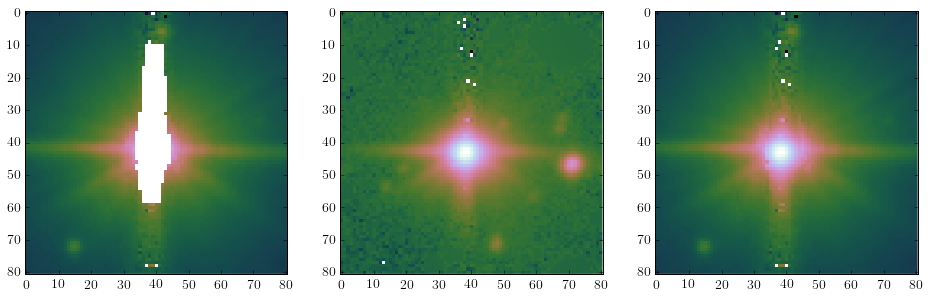

In [28]:
VegaCoords = SkyCoord(stars[0]['RA'], stars[0]['DEC'], unit=(u.hourangle, u.degree))
VegaPix = np.array(wcsutils.skycoord_to_pixel(VegaCoords, VegaCentredNoStars.wcs))

HD171872Coords = SkyCoord(stars[1]['RA'], stars[1]['DEC'], unit=(u.hourangle, u.degree))
HD171872Pix = np.array(wcsutils.skycoord_to_pixel(HD171872Coords, VegaCentredNoStars.wcs))

# Pixel coordinates of corners of a 80x 80 pixel box around Vega
VegaPixInt = VegaPix.astype(np.int)
VegaBox = (VegaPixInt[0]-40,VegaPixInt[0]+41,VegaPixInt[1]-40,VegaPixInt[1]+41)

# Similarly HD 171872
HDPixInt = HD171872Pix.astype(np.int)
HDBox = (HDPixInt[0]-40,HDPixInt[0]+41,HDPixInt[1]-40,HDPixInt[1]+41)

# For some reason it lines up great if you add a 2 pixel fudge factor to each axis
fudge = [2, -2]
fudgeBox = (HDBox[0]+fudge[0],HDBox[1]+fudge[0], HDBox[2]+fudge[1], HDBox[3]+fudge[1])

patch = np.where(VegaCentredNoStars.mask[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]], \
                 VegaCentred.data[fudgeBox[2]:fudgeBox[3],fudgeBox[0]:fudgeBox[1]] * FluxScale, \
                 VegaCentredNoStars.data[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]])
maskpatch = np.where(VegaCentredNoStars.mask[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]], \
                     VegaCentred.mask[fudgeBox[2]:fudgeBox[3],fudgeBox[0]:fudgeBox[1]], \
                     VegaCentredNoStars.mask[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]])
weightpatch = np.where(VegaCentredNoStars.mask[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]], \
                       VegaCentredWeight[fudgeBox[2]:fudgeBox[3],fudgeBox[0]:fudgeBox[1]] / FluxScale, \
                       VegaCentredNoStarsWeight[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]])

VegaCentredPatched = VegaCentredNoStars.copy()
VegaCentredPatched.data[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]] = patch
VegaCentredPatched.mask[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]] = maskpatch
VegaCentredPatched.write('VegaCentredPatched.fits', clobber=True)

VegaCentredPatchedWeight = VegaCentredNoStarsWeight.copy()
VegaCentredPatchedWeight.data[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]] = weightpatch
VegaCentredPatchedWeight.write('VegaCentredPatched.weight.fits', clobber=True)

n = LogNorm()
plt.subplot(1,3,1)
plt.imshow(VegaCentredNoStars.data[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]], \
           norm=n, interpolation='none', cmap='cubehelix', vmax=1e7)
plt.subplot(1,3,2)
plt.imshow(VegaCentredNoStars.data[fudgeBox[2]:fudgeBox[3],fudgeBox[0]:fudgeBox[1]] * FluxScale, \
           norm=n, interpolation='none', cmap='cubehelix')
plt.subplot(1,3,3)
plt.imshow(VegaCentredPatched.data[VegaBox[2]:VegaBox[3],VegaBox[0]:VegaBox[1]], \
          norm=n, interpolation='none', cmap='cubehelix')
plt.gcf().set_size_inches(16,5)

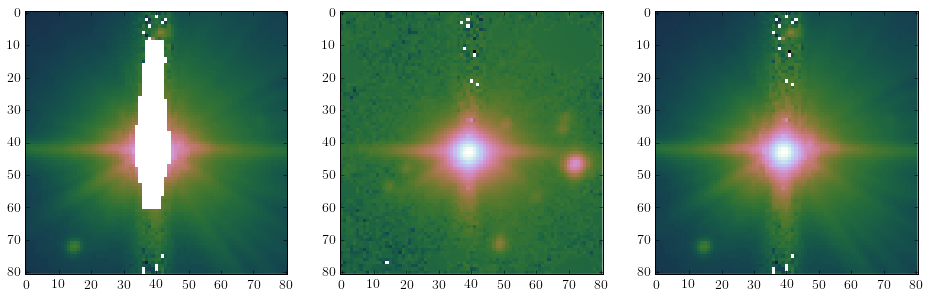

In [29]:
VegaPix2 = np.array(wcsutils.skycoord_to_pixel(VegaCoords, VegaOffCentreNoStars.wcs))

# Pixel coordinates of corners of a 80x 80 pixel box around Vega
VegaPixInt2 = VegaPix2.astype(np.int)
VegaBox2 = (VegaPixInt2[0]-40,VegaPixInt2[0]+41,VegaPixInt2[1]-40,VegaPixInt2[1]+41)

# For some reason it lines up great if you add a 2 pixel fudge factor to each axis
fudge2 = [1, -2]
fudgeBox2 = (HDBox[0]+fudge2[0],HDBox[1]+fudge2[0], HDBox[2]+fudge2[1], HDBox[3]+fudge2[1])

patch = np.where(VegaOffCentreNoStars.mask[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]], \
                 VegaCentred.data[fudgeBox2[2]:fudgeBox2[3],fudgeBox2[0]:fudgeBox2[1]] * FluxScale, \
                 VegaOffCentreNoStars.data[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]])
maskpatch = np.where(VegaOffCentreNoStars.mask[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]], \
                     VegaCentred.mask[fudgeBox2[2]:fudgeBox2[3],fudgeBox2[0]:fudgeBox2[1]], \
                     VegaOffCentreNoStars.mask[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]])
weightpatch = np.where(VegaOffCentreNoStars.mask[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]], \
                       VegaCentredWeight[fudgeBox2[2]:fudgeBox2[3],fudgeBox2[0]:fudgeBox2[1]] / FluxScale, \
                       VegaOffCentreNoStarsWeight[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]])

VegaOffCentrePatched = VegaOffCentreNoStars.copy()
VegaOffCentrePatched.data[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]] = patch
VegaOffCentrePatched.mask[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]] = maskpatch
VegaOffCentrePatched.write('VegaOffCentrePatched.fits', clobber=True)

VegaOffCentrePatchedWeight = VegaOffCentreNoStarsWeight.copy()
VegaOffCentrePatchedWeight.data[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]] = weightpatch
VegaOffCentrePatchedWeight.write('VegaOffCentrePatched.weight.fits', clobber=True)

n = LogNorm()
plt.subplot(1,3,1)
plt.imshow(VegaOffCentreNoStars.data[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]], \
           norm=n, interpolation='none', cmap='cubehelix', vmax=1e7)
plt.subplot(1,3,2)
plt.imshow(VegaCentredNoStars.data[fudgeBox2[2]:fudgeBox2[3],fudgeBox2[0]:fudgeBox2[1]] * FluxScale, \
           norm=n, interpolation='none', cmap='cubehelix')
plt.subplot(1,3,3)
plt.imshow(VegaOffCentrePatched.data[VegaBox2[2]:VegaBox2[3],VegaBox2[0]:VegaBox2[1]], \
          norm=n, interpolation='none', cmap='cubehelix')
plt.gcf().set_size_inches(16,5)

### Patch up saturated core of Fomalhaut using a flux scaled copy of a nearby bright star

Stars in question are Fomalhaut and CD-30 19368.  Fomalhaut $r' = 1.25 \pm 0.02$, CD-30 19368 $r' = 9.030 \pm 0.008$.

In [30]:
os.chdir(paths2['red'])

stars2 = s.query_objects(('Fomalhaut', 'CD-30 19368'))
stars2.pprint(max_width=115)

  MAIN_ID         RA           DEC      RA_PREC DEC_PREC ... SP_TYPE SP_QUAL      SP_BIBCODE     FLUX_V
               "h:m:s"       "d:m:s"                     ...                                      mag  
----------- ------------- ------------- ------- -------- ... ------- ------- ------------------- ------
  * alf PsA 22 57 39.0462 -29 37 20.053       9        9 ...     A4V       C 2006AJ....132..161G   1.16
CD-30 19368  22 57 29.632  -29 44 10.98       7        7 ...                                       9.46


In [31]:
FluxScale2 = np.float64(10**(0.4 * (9.030 - 1.25)))
FluxScale2

1294.1958414499863

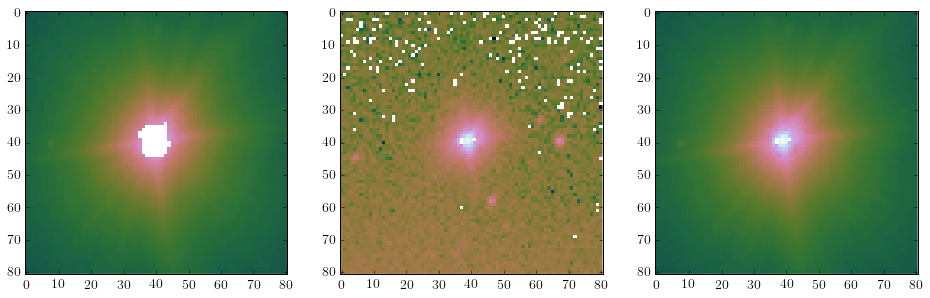

In [32]:
FomalhautCoords = SkyCoord(stars2[0]['RA'], stars2[0]['DEC'], unit=(u.hourangle, u.degree))
FomalhautPix = np.array(wcsutils.skycoord_to_pixel(FomalhautCoords, FomalhautANoStars.wcs))

CD30Coords = SkyCoord(stars2[1]['RA'], stars2[1]['DEC'], unit=(u.hourangle, u.degree))
CD30Pix = np.array(wcsutils.skycoord_to_pixel(CD30Coords, FomalhautANoStars.wcs))

# Pixel coordinates of corners of a 80x 80 pixel box around Vega
FomalhautPixInt = FomalhautPix.astype(np.int)
FomalhautBox = (FomalhautPixInt[0]-40,FomalhautPixInt[0]+41,FomalhautPixInt[1]-40,FomalhautPixInt[1]+41)

# Similarly CD-30 19368
CD30PixInt = CD30Pix.astype(np.int)
CD30Box = (CD30PixInt[0]-40,CD30PixInt[0]+41,CD30PixInt[1]-40,CD30PixInt[1]+41)

# For some reason it lines up great if you add a 2 pixel fudge factor to each axis
fudge3 = [2, 1]
fudgeBox3 = (CD30Box[0]+fudge3[0],CD30Box[1]+fudge3[0], CD30Box[2]+fudge3[1], CD30Box[3]+fudge3[1])

patch = np.where(FomalhautANoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                 FomalhautA.data[fudgeBox3[2]:fudgeBox3[3],fudgeBox3[0]:fudgeBox3[1]] * FluxScale2, \
                 FomalhautANoStars.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])
maskpatch = np.where(FomalhautANoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                     FomalhautA.mask[fudgeBox3[2]:fudgeBox3[3],fudgeBox3[0]:fudgeBox3[1]], \
                     FomalhautANoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])
weightpatch = np.where(FomalhautANoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                       FomalhautAWeight[fudgeBox3[2]:fudgeBox3[3],fudgeBox3[0]:fudgeBox3[1]] / FluxScale2, \
                       FomalhautANoStarsWeight[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])

FomalhautAPatched = FomalhautANoStars.copy()
FomalhautAPatched.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = patch
FomalhautAPatched.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = maskpatch
FomalhautAPatched.write('FomalhautAPatched.fits', clobber=True)

FomalhautAPatchedWeight = FomalhautANoStarsWeight.copy()
FomalhautAPatchedWeight.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = weightpatch
FomalhautAPatchedWeight.write('FomalhautAPatched.weight.fits', clobber=True)

n = LogNorm()
plt.subplot(1,3,1)
plt.imshow(FomalhautANoStars.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
           norm=n, interpolation='none', cmap='cubehelix', vmax=1e7)
plt.subplot(1,3,2)
plt.imshow(FomalhautA.data[fudgeBox3[2]:fudgeBox3[3],fudgeBox3[0]:fudgeBox3[1]] * FluxScale, \
           norm=n, interpolation='none', cmap='cubehelix')
plt.subplot(1,3,3)
plt.imshow(FomalhautAPatched.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
          norm=n, interpolation='none', cmap='cubehelix')
plt.gcf().set_size_inches(16,5)

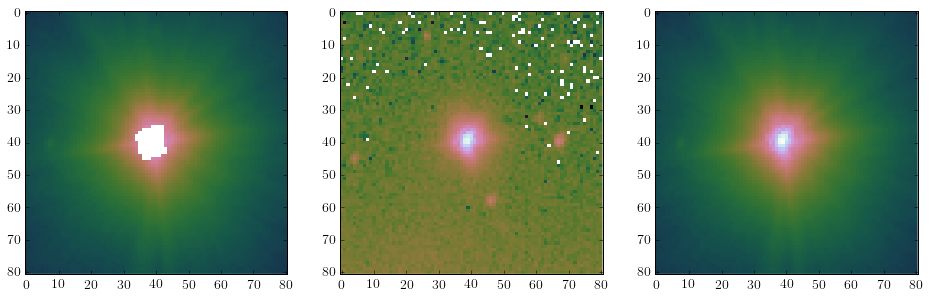

In [33]:
# For some reason it lines up great if you add a 2 pixel fudge factor to each axis
fudge4 = [2, 1]
fudgeBox4 = (CD30Box[0]+fudge4[0],CD30Box[1]+fudge4[0], CD30Box[2]+fudge4[1], CD30Box[3]+fudge4[1])

patch = np.where(FomalhautBNoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                 FomalhautB.data[fudgeBox4[2]:fudgeBox4[3],fudgeBox4[0]:fudgeBox4[1]] * FluxScale2, \
                 FomalhautBNoStars.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])
maskpatch = np.where(FomalhautBNoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                     FomalhautB.mask[fudgeBox4[2]:fudgeBox4[3],fudgeBox4[0]:fudgeBox4[1]], \
                     FomalhautBNoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])
weightpatch = np.where(FomalhautBNoStars.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
                       FomalhautBWeight[fudgeBox4[2]:fudgeBox4[3],fudgeBox4[0]:fudgeBox4[1]] / FluxScale2, \
                       FomalhautBNoStarsWeight[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]])

FomalhautBPatched = FomalhautBNoStars.copy()
FomalhautBPatched.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = patch
FomalhautBPatched.mask[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = maskpatch
FomalhautBPatched.write('FomalhautBPatched.fits', clobber=True)

FomalhautBPatchedWeight = FomalhautBNoStarsWeight.copy()
FomalhautBPatchedWeight.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]] = weightpatch
FomalhautBPatchedWeight.write('FomalhautBPatched.weight.fits', clobber=True)

n = LogNorm()
plt.subplot(1,3,1)
plt.imshow(FomalhautBNoStars.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
           norm=n, interpolation='none', cmap='cubehelix', vmax=1e7)
plt.subplot(1,3,2)
plt.imshow(FomalhautB.data[fudgeBox4[2]:fudgeBox4[3],fudgeBox4[0]:fudgeBox4[1]] * FluxScale, \
           norm=n, interpolation='none', cmap='cubehelix')
plt.subplot(1,3,3)
plt.imshow(FomalhautBPatched.data[FomalhautBox[2]:FomalhautBox[3],FomalhautBox[0]:FomalhautBox[1]], \
          norm=n, interpolation='none', cmap='cubehelix')
plt.gcf().set_size_inches(16,5)

### Normalise against total flux

Final step required to make these data actually useful is to estimate the total flux from the star and convert the pixel values to fraction of the total flux per square arcsecond, then we'll be able to say something about how bad the scattered light and ghost features actually are.

To estimate the total flux we'll calculate a cumulative radial profile ('curve of growth').  The remaining stars are an issue, will try some gentle sigma-clipping in the radial profile annuli.  Could probably do a better job using the catalogues to find the location of the bright stars and masking them that way.

In [34]:
# Set up arrays of position relative to nominal Vega position
pixscale = (VegaCentredPatched.header['CD2_2'] * u.degree).to(u.arcsecond)

cxs = (np.arange(VegaCentredPatched.shape[1]) - VegaPixInt[0] + fudge[0]) * pixscale
cys = (np.arange(VegaCentredPatched.shape[0]) - VegaPixInt[1] + fudge[1]) * pixscale
cX, cY = np.meshgrid(cxs, cys)
cR = np.hypot(cY,cX)
cA = np.arctan2(cY,cX)

ocxs = (np.arange(VegaOffCentrePatched.shape[1]) - VegaPixInt2[0] + fudge2[0]) * pixscale
ocys = (np.arange(VegaOffCentrePatched.shape[0]) - VegaPixInt2[1] + fudge2[1]) * pixscale
ocX, ocY = np.meshgrid(ocxs, ocys)
ocR = np.hypot(ocY,ocX)
ocA = np.arctan2(ocY,ocX)

In [35]:
#Set up arrays of position relative to nominal Vega position
pixscale2 = (FomalhautAPatched.header['CD2_2'] * u.degree).to(u.arcsecond)

faxs = (np.arange(FomalhautAPatched.shape[1]) - FomalhautPixInt[0] + fudge3[0]) * pixscale2
fays = (np.arange(FomalhautAPatched.shape[0]) - FomalhautPixInt[1] + fudge3[1]) * pixscale2
faX, faY = np.meshgrid(faxs, fays)
faR = np.hypot(faY,faX)
faA = np.arctan2(faY,faX)

fbxs = (np.arange(FomalhautAPatched.shape[1]) - FomalhautPixInt[0] + fudge4[0]) * pixscale2
fbys = (np.arange(FomalhautBPatched.shape[0]) - FomalhautPixInt[1] + fudge4[1]) * pixscale2
fbX, fbY = np.meshgrid(fbxs, fbys)
fbR = np.hypot(fbY,fbX)
fbA = np.arctan2(fbY,fbX)

In [36]:
rmax = 60 * u.arcminute
delta = 1.0 * pixscale
rs = np.arange((rmax/delta).to(u.dimensionless_unscaled)) * delta
counts = np.empty(rs.shape)
ocounts = np.empty(rs.shape)

for i, r in enumerate(rs):
    counts[i] = VegaCentredPatched.data[np.where(np.logical_and(cR >= r, cR < (r + delta)))].sum()
    ocounts[i] = VegaOffCentrePatched.data[np.where(np.logical_and(ocR >= r, ocR < (r + delta)))].sum()
    
ccounts = counts.cumsum()
cocounts = ocounts.cumsum()

In [37]:
rmax2 = 60 * u.arcminute
delta2 = 1.0 * pixscale2
r2s = np.arange((rmax2/delta2).to(u.dimensionless_unscaled)) * delta2
facounts = np.empty(r2s.shape)
fbcounts = np.empty(r2s.shape)

for i, r in enumerate(r2s):
    facounts[i] = FomalhautAPatched.data[np.where(np.logical_and(faR >= r, faR < (r + delta2)))].sum()
    fbcounts[i] = FomalhautBPatched.data[np.where(np.logical_and(fbR >= r, fbR < (r + delta2)))].sum()
    
cfacounts = facounts.cumsum()
cfbcounts = fbcounts.cumsum()

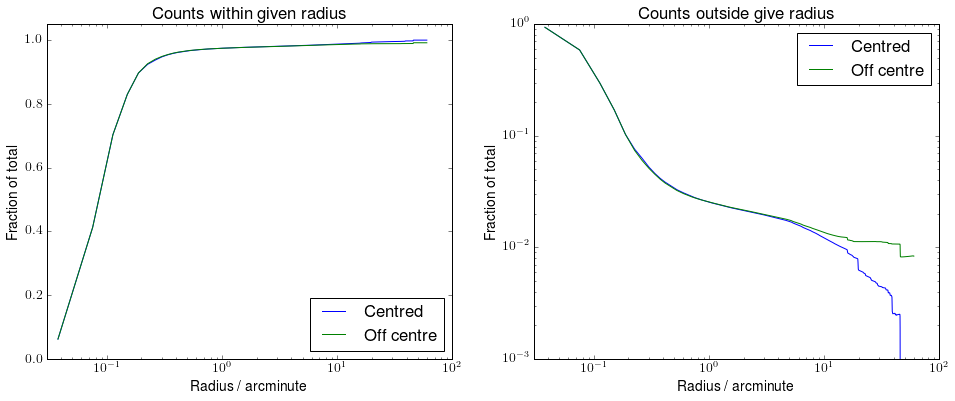

In [38]:
os.chdir(paths['red'])

plt.subplot(1,2,1)
plt.semilogx((rs + delta).to(u.arcminute), ccounts/ccounts[-1], label='Centred')
plt.semilogx((rs + delta).to(u.arcminute), cocounts/ccounts[-1], label='Off centre')
plt.xlim(3e-2,1e2)
plt.ylim(0,1.05)
plt.xlabel('Radius / arcminute')
plt.ylabel('Fraction of total')
plt.title('Counts within given radius')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.loglog((rs + delta).to(u.arcminute), 1 - ccounts/ccounts[-1], label='Centred')
plt.loglog((rs + delta).to(u.arcminute), 1 - cocounts/ccounts[-1], label='Off centre')
plt.xlim(3e-2,1e2)
plt.xlabel('Radius / arcminute')
plt.ylabel('Fraction of total')
plt.title('Counts outside give radius')
plt.ylim(1e-3,1)
plt.legend(loc='best')
plt.gcf().set_size_inches(16,6)
plt.savefig('profiles.png')

Based on curves of growth, etc., seems that the total counts within 1000" radius off the centre image will be within ~1% of the 'true' total value, which coincidentally is ~0.01 magnitudes.

In [39]:
np.where(np.logical_and(rs > 1000 * u.arcsecond - delta, rs < 1000*u.arcsecond + delta))

(array([442, 443]),)

In [40]:
rs[442]

<Quantity 999.3917046580366 arcsec>

In [41]:
total = ccounts[442]
total

126194767.68798828

In [42]:
cocounts[442]

125825721.5995636

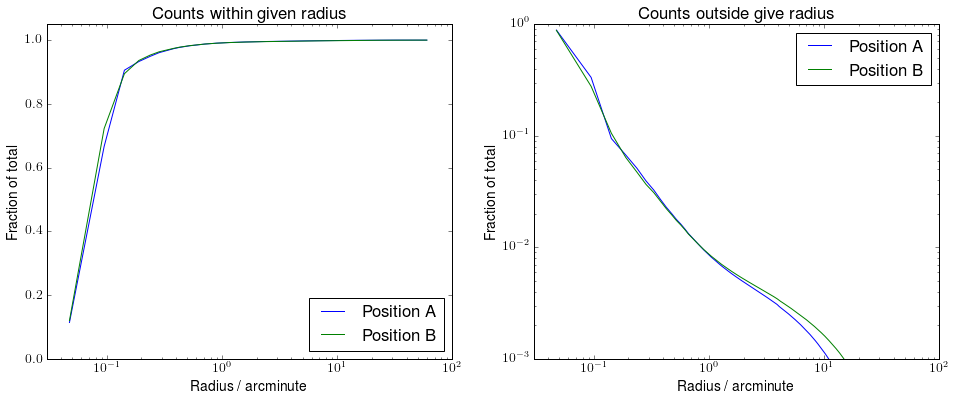

In [43]:
os.chdir(paths2['red'])

plt.subplot(1,2,1)
plt.semilogx((r2s + delta2).to(u.arcminute), cfacounts/cfacounts[-1], label='Position A')
plt.semilogx((r2s + delta2).to(u.arcminute), cfbcounts/cfbcounts[-1], label='Position B')
plt.xlim(3e-2,1e2)
plt.ylim(0,1.05)
plt.xlabel('Radius / arcminute')
plt.ylabel('Fraction of total')
plt.title('Counts within given radius')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.loglog((r2s + delta2).to(u.arcminute), 1 - cfacounts/cfacounts[-1], label='Position A')
plt.loglog((r2s + delta2).to(u.arcminute), 1 - cfbcounts/cfbcounts[-1], label='Position B')
plt.xlim(3e-2,1e2)
plt.xlabel('Radius / arcminute')
plt.ylabel('Fraction of total')
plt.title('Counts outside give radius')
plt.ylim(1e-3,1)
plt.legend(loc='best')
plt.gcf().set_size_inches(16,6)
plt.savefig('profiles.png')

In [44]:
np.where(np.logical_and(r2s > 1000 * u.arcsecond - delta2, r2s < 1000*u.arcsecond + delta2))

(array([351, 352]),)

In [45]:
r2s[351]

<Quantity 998.4991744626351 arcsec>

In [46]:
ta = cfacounts[351]
ta

37342608.605690002

In [47]:
tb = cfbcounts[351]
tb

39661408.87411499

Now convert pixel values (counts per pixel) to a relative surface brightness value, i.e. fraction of the total flux per unit solid angle.  Simple divide all values by the total counts and the solid angle of a pixel.

In [48]:
os.chdir(paths['red'])

factor = 1/(total * pixscale**2)

VegaCentredPatchedNorm = VegaCentredPatched.copy()
VegaCentredPatchedNorm.data *= factor
VegaCentredPatchedNorm.write('VegaCentredPatchedNorm.fits', clobber=True)

VegaOffCentrePatchedNorm = VegaOffCentrePatched.copy()
VegaOffCentrePatchedNorm.data *= factor
VegaOffCentrePatchedNorm.write('VegaOffCentrePatchedNorm.fits', clobber=True)

VegaDifferenceNorm = VegaCentredPatchedNorm.copy()
VegaDifferenceNorm.mask = np.logical_or(VegaCentredPatchedNorm.mask, VegaOffCentrePatchedNorm.mask)
VegaDifferenceNorm.data = np.where(VegaDifferenceNorm.mask, 0.0, \
                                   VegaCentredPatchedNorm.data - VegaOffCentrePatchedNorm.data)
VegaDifferenceNorm.write('VegaDifferenceNorm.fits', clobber=True)

VegaDifferenceNormNeg = VegaDifferenceNorm.copy()
VegaDifferenceNormNeg.data *= -1
VegaDifferenceNormNeg.write('VegaDifferenceNormNeg.fits', clobber=True)

VegaDifferenceWeight = VegaDifferenceNorm.copy()
VegaDifferenceWeight.data = np.where(np.logical_and(VegaCentredPatchedWeight.data, VegaOffCentrePatchedWeight.data), \
                                    2 / (1/VegaCentredPatchedWeight.data + 1/VegaOffCentrePatchedWeight.data), \
                                    0.0)
VegaDifferenceWeight.write('VegaDifference.weight.fits', clobber=True)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [49]:
os.chdir(paths2['red'])

factora = 1/(ta * pixscale2**2)
factorb = 1/(tb * pixscale2**2)

FomalhautAPatchedNorm = FomalhautAPatched.copy()
FomalhautAPatchedNorm.data *= factora
FomalhautAPatchedNorm.write('FomalhautAPatchedNorm.fits', clobber=True)

FomalhautBPatchedNorm = FomalhautBPatched.copy()
FomalhautBPatchedNorm.data *= factorb
FomalhautBPatchedNorm.write('FomalhautBPatchedNorm.fits', clobber=True)

FomalhautDifferenceNorm = FomalhautAPatchedNorm.copy()
FomalhautDifferenceNorm.mask = np.logical_or(FomalhautAPatchedNorm.mask, FomalhautBPatchedNorm.mask)
FomalhautDifferenceNorm.data = np.where(FomalhautDifferenceNorm.mask, 0.0, \
                                        FomalhautAPatchedNorm.data - FomalhautBPatchedNorm.data)
FomalhautDifferenceNorm.write('FomalhautDifferenceNorm.fits', clobber=True)

FomalhautDifferenceNormNeg = FomalhautDifferenceNorm.copy()
FomalhautDifferenceNormNeg.data *= -1
FomalhautDifferenceNormNeg.write('FomalhautDifferenceNormNeg.fits', clobber=True)

FomalhautDifferenceWeight = FomalhautDifferenceNorm.copy()
FomalhautDifferenceWeight.data = np.where(np.logical_and(FomalhautAPatchedWeight.data, FomalhautBPatchedWeight.data), \
                                         2 / (1/FomalhautAPatchedWeight.data + 1/FomalhautBPatchedWeight.data), \
                                         0.0)
FomalhautDifferenceWeight.write('FomalhautDifference.weight.fits', clobber=True)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


Attached is a summary image which shows, clockwise from top left, the final off centre Vega image, the final centred Vega image, off centre - centred difference image, and centred - off centre difference image.  All are displayed with the same log scale and colourmap.  The dominant features are 4 concentric defocussed ghosts, fairly well centred on the star.  The largest of these circles is a little under 1/2 a degree in diameter.  The difference images show that these features, and the fans of light above and below them, are fairly stable and subtract well despite the large difference in the position of the star relative to the optical axis.  What doesn't subtract well are the two large, complex features that I interpret as ghosts caused by reflections from the CCD to the Schmidt plate then back to the CCD.  These occur roughly on the opposite side of the optical axis to the primary stellar image.  The other feature visible in the difference image is an asymmetry in the rays of scattered light that occurs when the star is off centre.

The important question is whether all this mess is bright enough to cause us problems.  The way I've normalised these data is to divide the original pixel values by both the total counts from Vega and by the solid angle of a pixel so that the normalised pixel values can be interpreted as the fraction of the total flux per square arcsecond.  For example, the brightest parts of the Schmidt plate ghosts have pixel values of around 1.5e-8 so in the case of a 0th magnitude star (e.g. Vega...) they would have a surface brightness of -2.5 x log10(1.5e-8) = 19.6 mag/arcsec^2.  For a more sensible case of an 8th magnitude star in the field the resulting Schmidt plate ghosts would have peak surface brightness of around 27.6 mag/arcsec^2, down at the sort of level we might be able to live with, especially given that our large dither pattern will suppress mobile ghosts like these.  The fixed position ghosts span relative surface brightnesses of ~3e-8 to 1.5e-9, for an 8th magnitude star that would equate to 26.8 to 30.1 mag/arcsec^2.  So what do you guys think?  These super high dynamic range images make the RASA *look* absolutely awful but it seems the ghosts, etc., are actually really faint.  It's possible we could improve on this a bit too, my minimising the number of optical surfaces (e.g. putting our filter in place of the RASA's output window, ordering the camera with CCD cover glass removed), careful routing of the camera cables across the aperture, and baffling on the input side with a long dew shield & a knife edge baffle around the central obstruction (Christian Schwab's suggestion).

<img src=reduced/RASA/summary.png />

### Comparison of radial profiles with published Dragonfly Telephoto Array data

In the Dragonfly Telephoto Array instrument paper (Abraham & van Dokkum 2014) radial profiles are plotted in terms of the surface brightness ($r_{AB}$ mag/arcsec$^2$) at a given distance from Vega.  It's relatively easy for us to do essentially the same in V mag/arcsec$^2$, then convert to $r_{AB}$.

In [50]:
cms = np.zeros(rs.shape)
ocms = np.zeros(rs.shape)

cwms = np.zeros(rs.shape)
ocwms = np.zeros(rs.shape)

ccwms = np.zeros(rs.shape)
occwms = np.zeros(rs.shape)

for i, r in enumerate(rs):
    # Note, because both centred and off centred images are on the same pixel/coordinate grid
    # only need one set of pixel positions for each annulus
    annulus = np.where(np.logical_and(cR >= r, cR < (r + delta)))
    # Get pixels in annulus as a masked array
    cpix = np.ma.array(VegaCentredPatchedNorm.data[annulus], mask=VegaCentredPatchedNorm.mask[annulus])
    ocpix = np.ma.array(VegaOffCentrePatchedNorm.data[annulus], mask=VegaOffCentrePatchedNorm.mask[annulus])
    cweights = np.ma.array(VegaCentredPatchedWeight.data[annulus], mask=cpix.mask)
    ocweights = np.ma.array(VegaOffCentrePatchedWeight.data[annulus], mask=ocpix.mask)
    # Simple masked mean
    cm = np.ma.mean(cpix)
    ocm = np.ma.mean(ocpix)
    # Weighted mean
    cwm = np.ma.sum(cpix * cweights) / np.ma.sum(cweights)
    ocwm = np.ma.sum(ocpix * ocweights) / np.ma.sum(ocweights)
    # Clipped weighted mean
    if cpix.any():
        cpix_clipped = sigma_clip(cpix, sig=3.0, iters=None, cenfunc=np.ma.median)
        cweights_clipped = np.ma.array(cweights, mask=cpix_clipped.mask)
        ccwm = np.ma.sum(cpix_clipped * cweights_clipped) / np.ma.sum(cweights_clipped)
    else:
        ccwm = 1e-99
    if ocpix.any():
        ocpix_clipped = sigma_clip(ocpix, sig=3.0, iters=None, cenfunc=np.ma.median)
        ocweights_clipped = np.ma.array(ocweights, mask=ocpix_clipped.mask)
        occwm = np.ma.sum(ocpix_clipped * ocweights_clipped) / np.ma.sum(ocweights_clipped)
    else:
        occwm = 1e-99
    # Convert to mag/arcsec^2
    cms[i] = -2.5 * np.log10(cm) + 0.17 # Vega r=0.17
    ocms[i] = -2.5 * np.log10(ocm) + 0.17
    cwms[i] = -2.5 * np.log10(cwm) + 0.17 # Vega r=0.17
    ocwms[i] = -2.5 * np.log10(ocwm) + 0.17
    ccwms[i] = -2.5 * np.log10(ccwm) + 0.17 # Vega r=0.17
    occwms[i] = -2.5 * np.log10(occwm) + 0.17

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipyker

In [51]:
ams = np.zeros(r2s.shape)
bms = np.zeros(r2s.shape)

awms = np.zeros(r2s.shape)
bwms = np.zeros(r2s.shape)

acwms = np.zeros(r2s.shape)
bcwms = np.zeros(r2s.shape)

for i, r in enumerate(r2s):
    # Note, because both centred and off centred images are on the same pixel/coordinate grid
    # only need one set of pixel positions for each annulus
    annulus = np.where(np.logical_and(faR >= r, faR < (r + delta2)))
    # Get pixels in annulus as a masked array
    apix = np.ma.array(FomalhautAPatchedNorm.data[annulus], mask=FomalhautAPatchedNorm.mask[annulus])
    bpix = np.ma.array(FomalhautBPatchedNorm.data[annulus], mask=FomalhautBPatchedNorm.mask[annulus])
    aweights = np.ma.array(FomalhautAPatchedWeight.data[annulus], mask=apix.mask)
    bweights = np.ma.array(FomalhautBPatchedWeight.data[annulus], mask=bpix.mask)
    # Simple masked mean
    am = np.ma.mean(apix)
    bm = np.ma.mean(bpix)
    # Weighted mean
    awm = np.ma.sum(apix * aweights) / np.ma.sum(aweights)
    bwm = np.ma.sum(bpix * bweights) / np.ma.sum(bweights)
    # Clipped weighted mean
    if apix.any():
        apix_clipped = sigma_clip(apix, sig=3.0, iters=None, cenfunc=np.ma.median)
        aweights_clipped = np.ma.array(aweights, mask=apix_clipped.mask)
        acwm = np.ma.sum(apix_clipped * aweights_clipped) / np.ma.sum(aweights_clipped)
    else:
        acwm = 1e-99
    if bpix.any():
        bpix_clipped = sigma_clip(bpix, sig=3.0, iters=None, cenfunc=np.ma.median)
        bweights_clipped = np.ma.array(bweights, mask=bpix_clipped.mask)
        bcwm = np.ma.sum(bpix_clipped * bweights_clipped) / np.ma.sum(bweights_clipped)
    else:
        bcwm = 1e-99
    # Convert to mag/arcsec^2
    ams[i] = -2.5 * np.log10(am) + 0.17 # Vega r=0.17
    bms[i] = -2.5 * np.log10(bm) + 0.17
    awms[i] = -2.5 * np.log10(awm) + 0.17 # Vega r=0.17
    bwms[i] = -2.5 * np.log10(bwm) + 0.17
    acwms[i] = -2.5 * np.log10(acwm) + 0.17 # Vega r=0.17
    bcwms[i] = -2.5 * np.log10(bcwm) + 0.17

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in log10


In [52]:
Burrell = Table.read('../../other/Burrell.csv')
Dragonfly = Table.read('../../other/Dragonfly.csv')

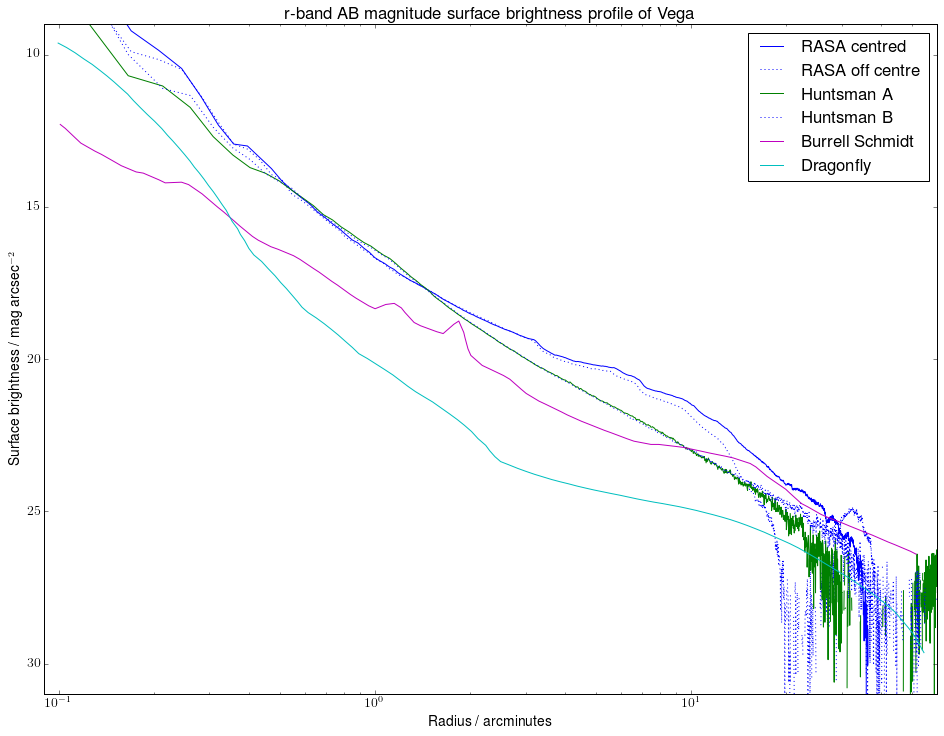

In [53]:
#plt.semilogx((rs + delta/2.0).to(u.arcminute), cms, 'b:', label='RASA centred')
#plt.semilogx((rs + delta/2.0).to(u.arcminute), cwms, 'b--', label='RASA centred')
plt.semilogx((rs + delta/2.0).to(u.arcminute), ccwms, 'b-', label='RASA centred')
#plt.semilogx((rs + delta/2.0).to(u.arcminute), ocms, 'b:', label='RASA off centre')
#plt.semilogx((rs + delta/2.0).to(u.arcminute), ocwms, 'b--', label='RASA off centre')
plt.semilogx((rs + delta/2.0).to(u.arcminute), occwms, 'b:', label='RASA off centre')
#plt.semilogx((r2s + delta2/2.0).to(u.arcminute), ams, 'g:', label='Huntsman A')
#plt.semilogx((r2s + delta2/2.0).to(u.arcminute), awms, 'g--', label='Huntsman A')
plt.semilogx((r2s + delta2/2.0).to(u.arcminute), acwms, 'g-', label='Huntsman A')
#plt.semilogx((r2s + delta2/2.0).to(u.arcminute), bms, 'g:', label='Hunsman B')
#plt.semilogx((r2s + delta2/2.0).to(u.arcminute), bwms, 'g--', label='Huntsman B')
plt.semilogx((r2s + delta2/2.0).to(u.arcminute), bcwms, 'b:', label='Huntsman B')
plt.semilogx(Burrell['radius'], Burrell['sb'], 'm-', label='Burrell Schmidt')
plt.semilogx(Dragonfly['radius'], Dragonfly['sb'], 'c-', label='Dragonfly')
plt.xlim(0.09,60)
plt.ylim(31,9)
plt.xlabel('Radius / arcminutes')
plt.ylabel('Surface brightness / mag arcsec$^{-2}$')
plt.title('r-band AB magnitude surface brightness profile of Vega')
plt.legend(loc=1)
plt.gcf().set_size_inches(16,12)
plt.savefig('comparison.png')

This seems surprisingly terrible.  Run our Canon data through the same process to check?

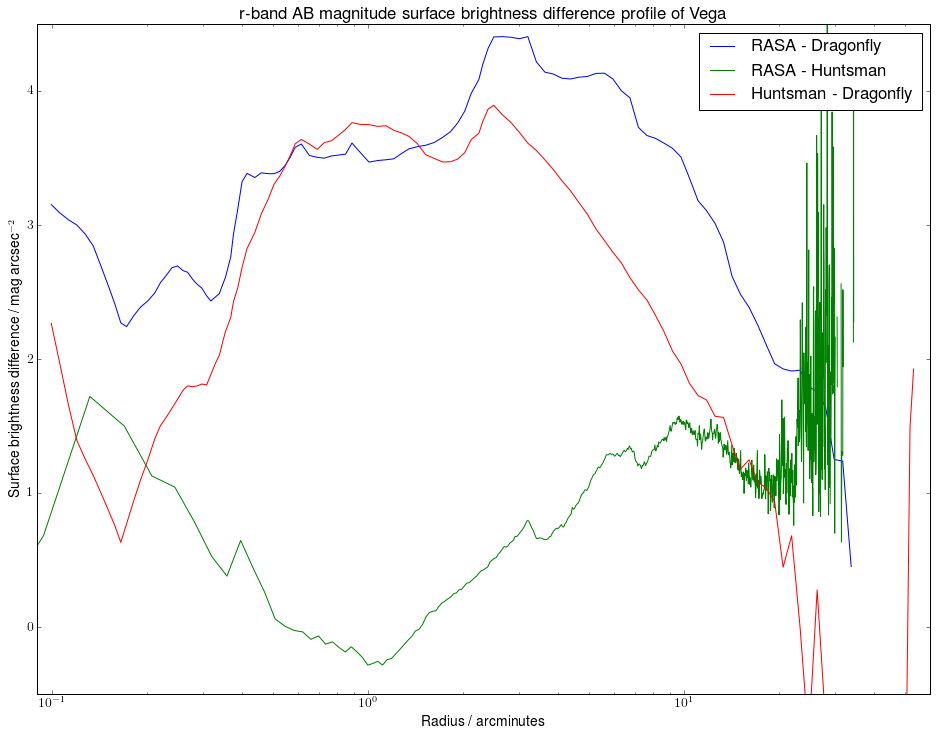

In [54]:
plt.semilogx(Dragonfly['radius'], \
             Dragonfly['sb'] - np.interp(Dragonfly['radius'], (rs + delta/2.0).to(u.arcminute), ccwms), 
            label='RASA - Dragonfly')
plt.semilogx((rs + delta/2.0).to(u.arcminute), \
             np.interp((rs + delta/2.0).to(u.arcminute), (r2s + delta2/2.0).to(u.arcminute), acwms) - ccwms, 
            label='RASA - Huntsman')
plt.semilogx(Dragonfly['radius'], \
             Dragonfly['sb'] - np.interp(Dragonfly['radius'], (r2s + delta2/2.0).to(u.arcminute), acwms), 
            label='Huntsman - Dragonfly')
plt.ylim(-0.5,4.5)
plt.xlim(0.09,60)
plt.xlabel('Radius / arcminutes')
plt.ylabel('Surface brightness difference / mag arcsec$^{-2}$')
plt.title('r-band AB magnitude surface brightness difference profile of Vega')
plt.legend(loc=1)
plt.gcf().set_size_inches(16,12)
plt.savefig('comparison2.png')

### Surface brightness variability

The level of variability in the wings of the PSF important in assessing how problematic they will be, not just the brightness.  For a simple quantification of this will construct radial profiles of the absolute value of the difference images created from the two pointing positions for both RASA and Huntsmans.

In [91]:
def radial_profile(image, weight, coords, fudge, max_radius, delta_radius, zero_point, sigma=False, absolute=False):
    
    # Position of star in pixel coordinates
    origin = wcsutils.skycoord_to_pixel(coords, image.wcs)
    # Coordinates relative to star in pixels
    x = np.arange(image.shape[1]) - origin[0] + fudge[0]
    y = np.arange(image.shape[0]) - origin[1] + fudge[1]
    # Make 2 x N_pixel array containing (x, y) pixel coordinates of each pixel
    XY = np.array(np.meshgrid(x, y)).reshape(2,x.size*y.size)
    # Convert pixel coordinates to degrees and reshape to 2 x image shape
    XdYd = image.wcs.pixel_scale_matrix.dot(XY).reshape(2,y.size,x.size)
    # Radial distance of each pixel from origin
    R = np.hypot(XdYd[1], XdYd[0]) * u.degree
    # Angular position of each pixel relative to origin
    A = np.arctan2(XdYd[1], XdYd[0]) * u.radian
    
    # Inner radii for annuli
    inner_radii = np.arange(0, max_radius.to(u.degree).value, delta_radius.to(u.degree).value) * u.degree
    
    # Empty arrays for storing results
    n_radii = len(inner_radii)
    mags = np.empty(n_radii)
    
    for i, inner_radius in enumerate(inner_radii):
        outer_radius = inner_radius + delta_radius
        # Indices of pixels within annulus and non-zero weight
        annulus = np.where(np.logical_and(np.logical_and(R >= inner_radius, R < outer_radius), 
                                         weight > 0))
        # Get pixel values and corresponding weights as masked arrays
        pix_vals = image.data[annulus]
        pix_weights = weight.data[annulus]
        # Check that there are some non-zero, non-zero weighted pixels within annulus
        if pix_vals.any():
            # Optionally take absolute value of pixels before calculating mean
            # (intended for use with difference images)
            if absolute: 
                pix_vals = np.absolute(pix_vals)
            # Optionally sigma clip extreme pixel values
            if sigma:
                pix_vals = sigma_clip(pix_vals, sig=sigma, iters=None, cenfunc=np.ma.median)
                pix_weights = np.ma.array(pix_weights, mask=pix_vals.mask)
            # Calculate weighted mean
            weighted_mean = np.ma.sum(pix_vals * pix_weights) / np.ma.sum(pix_weights)
        else:
            # No vald pixel values in annulus, i.e. annulus completely outside value region of image
            weighted_mean = 1e-99
        # Convert to magnitudes
        mags[i] = -2.5 * np.log10(weighted_mean) + zero_point
        
    return inner_radii, mags

In [92]:
pixscale

<Quantity 2.26106720510868 arcsec>

In [121]:
inners, C = radial_profile(VegaCentredPatchedNorm, VegaCentredPatchedWeight, VegaCoords, fudge, \
                           60 * u.arcminute, pixscale, 0.17, sigma=3.0)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in float_scalars


In [122]:
inners, O = radial_profile(VegaOffCentrePatchedNorm, VegaOffCentrePatchedWeight, VegaCoords, fudge2, \
                           60 * u.arcminute, pixscale, 0.17, sigma=3.0)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in log10
/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in float_scalars


In [123]:
inners, Cabs = radial_profile(VegaCentredPatchedNorm, VegaCentredPatchedWeight, VegaCoords, fudge, \
                              60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in float_scalars


In [124]:
inners, Oabs = radial_profile(VegaOffCentrePatchedNorm, VegaOffCentrePatchedWeight, VegaCoords, fudge2, \
                           60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in float_scalars


In [125]:
inners, Vdiff = radial_profile(VegaDifferenceNorm, VegaDifferenceWeight, VegaCoords, fudge, \
                               60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in float_scalars


In [126]:
inners, A = radial_profile(FomalhautAPatchedNorm, FomalhautAPatchedWeight, FomalhautCoords, fudge3, \
                           60 * u.arcminute, pixscale, 0.17, sigma=3.0)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in log10


In [127]:
inners, B = radial_profile(FomalhautBPatchedNorm, FomalhautBPatchedWeight, FomalhautCoords, fudge4, \
                           60 * u.arcminute, pixscale, 0.17, sigma=3.0)

/mnt/data/ajh/Documents/virtualenvs/python2.7.6/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in log10


In [128]:
inners, Aabs = radial_profile(FomalhautAPatchedNorm, FomalhautAPatchedWeight, FomalhautCoords, fudge3, \
                              60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

In [129]:
inners, Babs = radial_profile(FomalhautBPatchedNorm, FomalhautBPatchedWeight, FomalhautCoords, fudge4, \
                              60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

In [130]:
inners, diff = radial_profile(FomalhautDifferenceNorm, FomalhautDifferenceWeight, FomalhautCoords, fudge3, \
                              60 * u.arcminute, pixscale, 0.17, sigma=3.0, absolute=True)

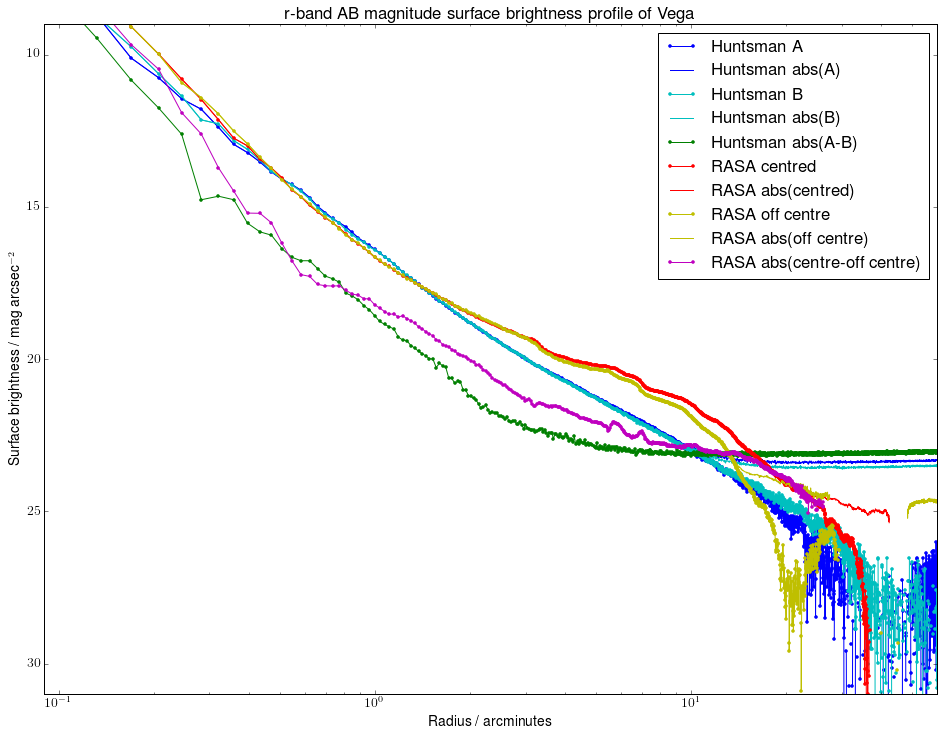

In [138]:
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), A, 'b.-', label='Huntsman A')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), Aabs, 'b-', label='Huntsman abs(A)')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), B, 'c.-', label='Huntsman B')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), Babs, 'c-', label='Huntsman abs(B)')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), diff, 'g.-', label='Huntsman abs(A-B)')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), C, 'r.-', label='RASA centred')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), Cabs, 'r-', label='RASA abs(centred)')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), O, 'y.-', label='RASA off centre')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), Oabs, 'y-', label='RASA abs(off centre)')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), Vdiff, 'm.-', label='RASA abs(centre-off centre)')
plt.xlim(0.09,60)
plt.ylim(31,9)
plt.xlabel('Radius / arcminutes')
plt.ylabel('Surface brightness / mag arcsec$^{-2}$')
plt.title('r-band AB magnitude surface brightness profile of Vega')
plt.legend(loc=1)
plt.gcf().set_size_inches(16,12)
plt.savefig('profiles.png')

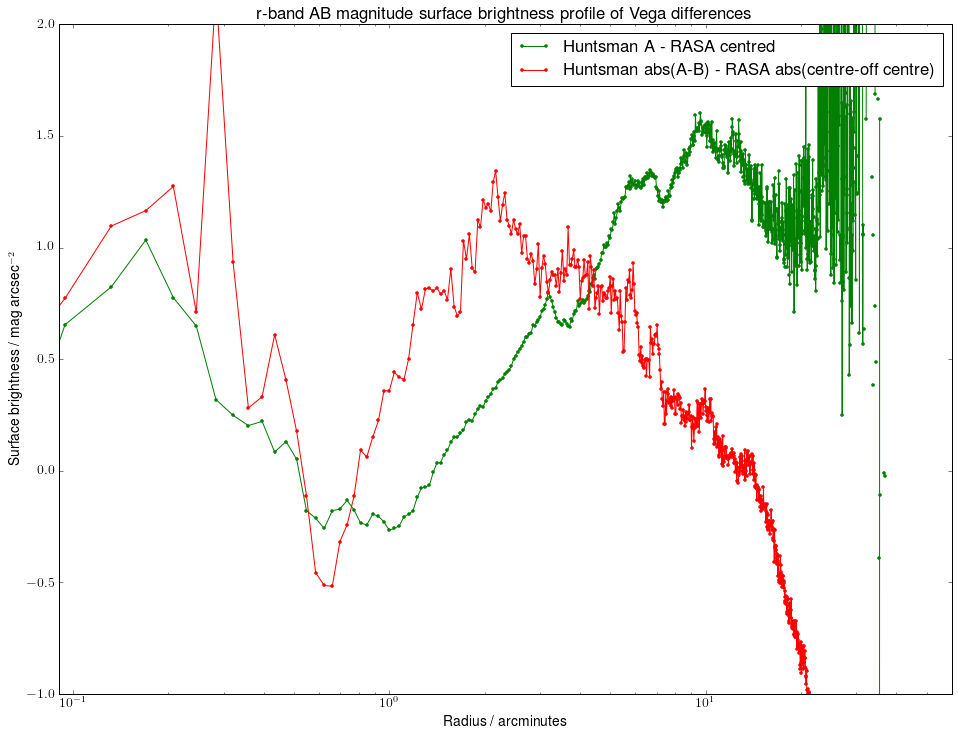

In [139]:
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), A - C, 'g.-', label='Huntsman A - RASA centred')
plt.semilogx((inners + pixscale/2.0).to(u.arcminute), diff - Vdiff, 'r.-', label='Huntsman abs(A-B) - RASA abs(centre-off centre)')
plt.xlim(0.09,60)
plt.ylim(-1,2)
plt.xlabel('Radius / arcminutes')
plt.ylabel('Surface brightness / mag arcsec$^{-2}$')
plt.title('r-band AB magnitude surface brightness profile of Vega differences')
plt.legend(loc=1)
plt.gcf().set_size_inches(16,12)
plt.savefig('differences.png')

In [99]:
A

array([  4.75276997,   5.97195586,   7.86132296,   9.23482617,
        10.64623674,  11.29502316,  11.98349734,  12.32901593,
        12.92056819,  13.48179003,  13.75244637,  14.06101008,
        14.38966413,  14.63097831,  14.80001827,  14.99008914,
        15.22884747,  15.52090426,  15.72484156,  15.9171774 ,
        16.05938574,  16.1912777 ,  16.37546798,  16.54982825,
        16.68583771,  16.80330893,  16.92532202])